In [12]:
from algorithms.epsilon_greedy.standard import *
from testing_framework.tests import test_algorithm
from arms.bernoulli import BernoulliArm
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [13]:
import random

random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(ind_max(means)))
final_results = []

f = open("algorithms/epsilon_greedy/standard_results.tsv", "w")

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
  algo = EpsilonGreedy(epsilon, [], [])
  algo.initialize(n_arms)
  results = test_algorithm(algo, arms, 50, 500)
  for i in range(len(results[0])):
      final_results.append([results[j][i] for j in range(len(results))])
      f.write(str(epsilon) + "\t")
      f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

f.close()


Best arm is 4


In [14]:
#maximum percentage for each epsilon
0.9*.9 + .1*.1
for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    max_p = np.max(means)*(1-eps) + np.mean(means) * eps
    print(f"Max percentage for epsilon {eps} is {max_p}")

Max percentage for epsilon 0.1 is 0.8360000000000001
Max percentage for epsilon 0.2 is 0.7720000000000001
Max percentage for epsilon 0.3 is 0.708
Max percentage for epsilon 0.4 is 0.644
Max percentage for epsilon 0.5 is 0.5800000000000001


In [15]:
df = pd.DataFrame(np.array(final_results), columns=["sim_nums", "epsilon", "times", "chosen_arms", "rewards", "cumulative_rewards"])
df["mean_rewards"] = df.cumulative_rewards / df.times

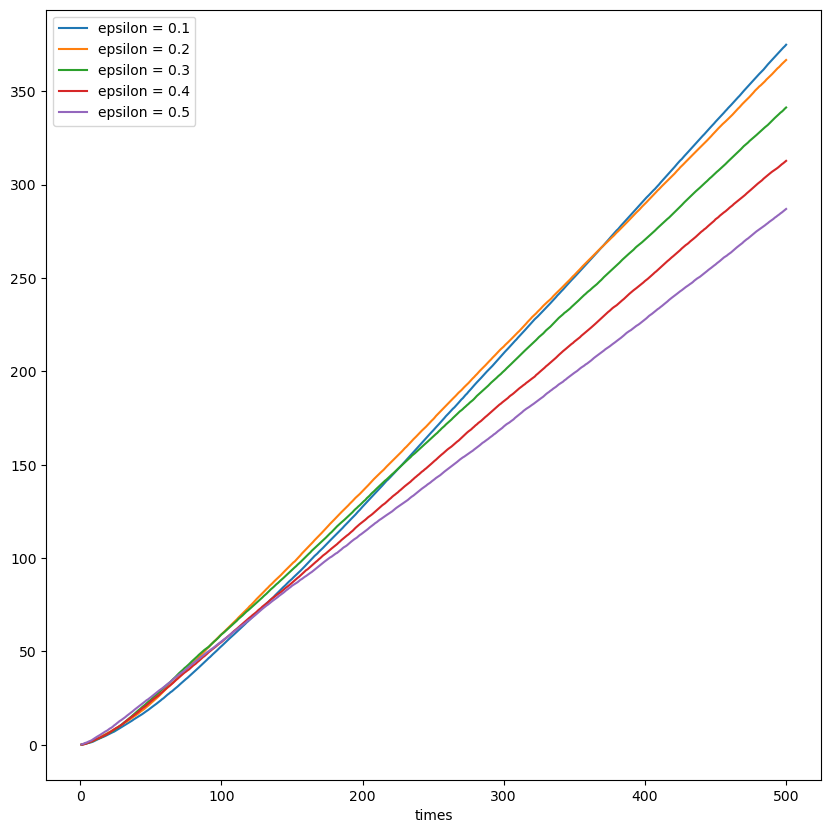

In [16]:
ax, fig = plt.subplots(figsize=(10, 10))
df_mean = df.groupby(["epsilon", "times"]).mean().reset_index()
for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    df_mean[df_mean.epsilon == eps].plot(x="times", y="cumulative_rewards", label="epsilon = " + str(eps), ax=fig)
plt.show()

In [17]:
import plotly.graph_objects as go

fig = go.Figure()

df_mean = df.groupby(["epsilon", "times"]).mean().reset_index()

for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    df_eps = df_mean[df_mean.epsilon == eps]
    fig.add_trace(go.Scatter(x=df_eps["times"], y=df_eps["cumulative_rewards"],
                             mode='lines',
                             name="epsilon = " + str(eps)))

fig.update_layout(
    title="Cumulative Rewards vs Times",
    xaxis_title="Times",
    yaxis_title="Cumulative Rewards",
    autosize=False,
    width=800,
    height=800
)

fig.show()

In [18]:
import plotly.graph_objects as go

fig = go.Figure()

df_mean = df.groupby(["epsilon", "times"]).mean().reset_index()

for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    df_eps = df_mean[df_mean.epsilon == eps]
    fig.add_trace(go.Scatter(x=df_eps["times"], y=df_eps["mean_rewards"],
                             mode='lines',
                             name="epsilon = " + str(eps)))

fig.update_layout(
    title="Mean Rewards vs Times",
    xaxis_title="Times",
    yaxis_title="Cumulative Rewards",
    autosize=False,
    width=800,
    height=800
)

fig.show()

<Axes: xlabel='chosen_arms'>

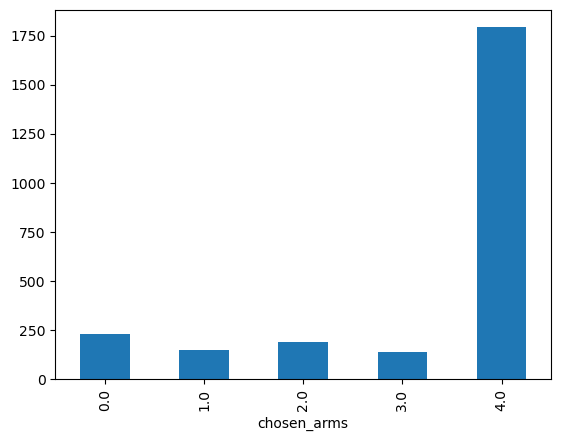

In [19]:
df.query("sim_nums == 1").groupby("chosen_arms").size().plot(kind="bar")
# show the bar quantity in the same plot above
# df.query("sim_nums == 1").groupby("chosen_arms").size().plot("")

In [20]:
(df.groupby(["epsilon", "sim_nums"])["cumulative_rewards"].max()
 .groupby("epsilon").mean())

epsilon
0.1    374.98
0.2    366.80
0.3    341.36
0.4    312.78
0.5    287.02
Name: cumulative_rewards, dtype: float64

In [21]:
# df1 = df.query("sim_nums == 1")
# checando que se as probabilidades foram respeitadas
(df
 .groupby("chosen_arms")["rewards"]
 .agg([np.sum, 'count'])
 .assign(percentage = lambda x: 100.0*x["sum"]/x["count"])
 ).head()

,sum,count,percentage
chosen_arms,,,
0.0,1157.0,11813,9.794294
1.0,762.0,7965,9.566855
2.0,842.0,7968,10.567269
3.0,760.0,7671,9.907444
4.0,80626.0,89583,90.001451


In [23]:
(df
 .groupby("chosen_arms")["rewards"]
 .agg([np.sum, 'count'])
 .assign(percentage = lambda x: 100.0*x["sum"]/x["count"])
 ).head()

,sum,count,percentage
chosen_arms,,,
0.0,1157.0,11813,9.794294
1.0,762.0,7965,9.566855
2.0,842.0,7968,10.567269
3.0,760.0,7671,9.907444
4.0,80626.0,89583,90.001451


In [ ]:
def test_algorithm(algo, arms, num_sims, horizon):
  chosen_arms = [0.0 for i in range(num_sims * horizon)]
  rewards = [0.0 for i in range(num_sims * horizon)]
  cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
  sim_nums = [0.0 for i in range(num_sims * horizon)]
  times = [0.0 for i in range(num_sims * horizon)]
  eps = [algo.epsilon]*(num_sims * horizon)
  
  for sim in range(num_sims):
    sim = sim + 1
    algo.initialize(len(arms))
    
    for t in range(horizon):
      t = t + 1
      index = (sim - 1) * horizon + t - 1
      sim_nums[index] = sim
      times[index] = t
      
      chosen_arm = algo.select_arm()
      chosen_arms[index] = chosen_arm
      
      reward = arms[chosen_arms[index]].draw()
      rewards[index] = reward
      
      if t == 1:
        cumulative_rewards[index] = reward
      else:
        cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
      
      algo.update(chosen_arm, reward)
  
  return [sim_nums, eps, times, chosen_arms, rewards, cumulative_rewards]

